In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Get the x_test and y_test

In [51]:
import pandas as pd
import numpy as np
from sklearn import preprocessing

base_dir = "/content/drive/My Drive/Google_Colab"
# test_data consist 5 sampels save in an excel file. Read each sample by calling its corresponding sheet
df = pd.read_excel(base_dir + '/' + 'test_data_3.xlsx', index_col = 0, sheet_name='sample1')

labels = df.index.tolist()
# get binary labels: if label=push, then is 1, and if label='other', then is 0


r = 4    #number of videos
m = 125     # number of frames (padded to max-len): this info is got from last block
n = 75    # number of landmark vector-size


def binary_label(labels):
    binary_labels = []
    for l in labels:
        if l.split('_')[0]=='push':
            #binary_labels.append(1)
            binary_labels.append(np.ones(m))
        else:
            #binary_labels.append(0)
            binary_labels.append(np.zeros(m))
    return binary_labels

# get list of labels as 0 and 1
test_label_list = binary_label(labels)

# get x_train and Normalize it so all numbers get scaled between 0-1
input_data = df.values
min_max_scaler = preprocessing.MinMaxScaler()
x_test_scaled = min_max_scaler.fit_transform(input_data)

# reshaping the data to get the original shape of the input data
# each sample consists of 4 videos including 2 actions as pushing and 2 actions as other. all 4 videos are coupled
# and given as one test sample to the model (this method is used to avoid manual labeling)

x_test= x_test_scaled.reshape(r, m, n)
y_test = np.asarray(test_label_list)            #convert label list to numpy array
y_test = y_test.reshape(y_test.shape[0], y_test.shape[1], 1)    #reshape y_label to the correct shape

print(x_test.shape)
print (y_test.shape)

(4, 125, 75)
(4, 125, 1)


### Loading the trained model

In [52]:
from tensorflow.python.keras.models import model_from_json


json_file = open(base_dir + '/saved_models'+'/P06_LSTM_model7.json')
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(base_dir +'/saved_models' +'/P06_LSTM_model7.h5')
print("Loaded model from disk")

Loaded model from disk


In [0]:
loaded_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])   

## Evaluate model on test data

In [54]:
scores = loaded_model.evaluate(x_test, y_test,batch_size=1)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], scores[1]*100))

4/4 [==============================] - 0s 8ms/step - loss: 0.3767 - accuracy: 0.7560
accuracy: 75.60%


## Timelabel.json file

In [55]:
predictions = loaded_model.predict(x= x_test)
predictions.shape

(4, 125, 1)

In [0]:
import json

#my video length that gives 125 jsonfile (125 frame) is 4 second. since I have done padding to maxlen of 125 frames it means that I have considered the first 4 seconds of each video.
# So each sample consisits of 4 vides. and it means the video sample length are 12 seconds. (4*4 =16)  
vid_len = 16      
n = predictions.shape[0]*predictions.shape[1]

preds = predictions.reshape(n,)

json = "{\"push\":["
values = []
times = np.linspace(0.1,vid_len,n)

for i in range(len(preds)):
    l = "["
    #time += 0.5
    time = times[i]
    l += str(time)
    l += ','
    l += str(preds[i])
    l += "]"
    l += ","
    json += l

json = json[:-1]
    
json += "]}"

## Saving TimeLabel JSON file

In [0]:
with open(base_dir+'/timelabel_json'+'/timelabel_sample2_model1.json', 'w') as f:
    f.write(json)

## Plotting TimeLable v.s time

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

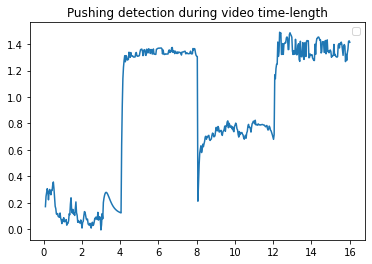

<Figure size 432x288 with 0 Axes>

In [57]:
import matplotlib.pyplot as plt   
%matplotlib inline

# Plot Training and Validation accuracy over epoch
plt.plot(times, preds)
plt.title('Pushing detection during video time-length')
plt.legend()

plt.figure()